<a href="https://colab.research.google.com/github/amitpaul05/Journey-to-AI/blob/master/Multi_layer_perceptron.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'credit-card-customer-churn-prediction:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F869651%2F1481789%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240910%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240910T174405Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D995688569c03309d14e70c5deba0c3a1e28e73f873759cd1ff42ebf2058839dc32ec7def2b11ad55ce30d6f66eda71a9f34beb0ac71d0fbed2eca0c3f3815a5fe9de2ab1c144c7228e96cea709616c8dc9f625bcca9e0577a40279685a5fd9b4520366f89694bf4dc16b412a1518d66015b90f9e21101fffadb431e20ba5a00473d2ef71bc83c2b6bca96660a50a925317c9959a9deb4d7573382085097981331e54fd7f1a9c78f3320c355c526ba987dc2d14c260c7162e65462ece8acf52b4f3b40e3b776ec5fe2ba2a11ce140b238ef78908ce6b96bfd604c45a2a1287919a7d12263ee5db08abe6821aba676202ed476aa1e68f17694b86e8fad1d00d8eb'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')

[==================================================] 267794 bytes downloaded
Downloaded and uncompressed: credit-card-customer-churn-prediction
Data source import complete.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/credit-card-customer-churn-prediction/Churn_Modelling.csv


In [3]:
df = pd.read_csv('/kaggle/input/credit-card-customer-churn-prediction/Churn_Modelling.csv')
df.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [4]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [6]:
df.duplicated().sum()

0

In [7]:
df.drop(columns=['RowNumber', 'CustomerId', 'Surname'], inplace=True)

In [8]:
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [9]:
df = pd.get_dummies(df, columns=['Geography', 'Gender'], drop_first=True)

In [10]:
X = df.drop(['Exited'], axis=1)
y = df['Exited']

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=1)

In [12]:
X_train.shape

(8000, 11)

In [13]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [14]:
X_train_scaler = scaler.fit_transform(X_train)
X_test_scaler = scaler.transform(X_test)

In [15]:
X_train_scaler

array([[-0.23082038, -0.94449979, -0.70174202, ...,  1.71490137,
        -0.57273139,  0.91509065],
       [-0.25150912, -0.94449979, -0.35520275, ..., -0.58312392,
        -0.57273139, -1.09278791],
       [-0.3963303 ,  0.77498705,  0.33787579, ...,  1.71490137,
        -0.57273139, -1.09278791],
       ...,
       [ 0.22433188,  0.58393295,  1.3774936 , ..., -0.58312392,
        -0.57273139, -1.09278791],
       [ 0.13123255,  0.01077067,  1.03095433, ..., -0.58312392,
        -0.57273139, -1.09278791],
       [ 1.1656695 ,  0.29735181,  0.33787579, ...,  1.71490137,
        -0.57273139,  0.91509065]])

In [16]:
import tensorflow
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

In [17]:
model = Sequential()

In [18]:
model.add(Dense(11, activation='relu', input_dim=11))
model.add(Dense(11, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [19]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 11)                  │             132 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 11)                  │             132 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              12 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 276 (1.08 KB)

 Trainable params: 276 (1.08 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [21]:
history = model.fit(X_train_scaler, y_train, epochs=500, validation_split=0.2)

Epoch 1/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.6684 - loss: 0.6004 - val_accuracy: 0.7981 - val_loss: 0.4821
Epoch 2/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7982 - loss: 0.4669 - val_accuracy: 0.8006 - val_loss: 0.4525
Epoch 3/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8092 - loss: 0.4241 - val_accuracy: 0.8012 - val_loss: 0.4334
Epoch 4/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8049 - loss: 0.4292 - val_accuracy: 0.8188 - val_loss: 0.4169
Epoch 5/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8169 - loss: 0.4145 - val_accuracy: 0.8244 - val_loss: 0.4017
Epoch 6/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8312 - loss: 0.4021 - val_accuracy: 0.8281 - val_loss: 0.3870
Epoch 7/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8373 - loss: 0.3827 - val_accuracy: 0.8369 - val_loss: 0.3744
Epoch 8/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8414 - loss: 0.3804 - val_accu

In [22]:
model.layers[2].get_weights()

[array([[-0.5452695 ],
        [ 0.9826679 ],
        [-0.93237376],
        [ 1.043059  ],
        [-1.1157365 ],
        [ 1.2958205 ],
        [ 0.74852353],
        [ 0.91757804],
        [ 1.1841868 ],
        [-0.7326439 ],
        [ 0.99658006]], dtype=float32),
 array([-0.06550914], dtype=float32)]

In [23]:
y_log = model.predict(X_test_scaler)
print(y_log)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
[[0.00597722]
 [0.08048224]
 [0.12831339]
 ...
 [0.00716378]
 [0.03084232]
 [0.3905263 ]]


In [24]:
y_pred = np.where(y_log>0.5,1,0)
print(y_pred)

[[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]


In [25]:
import sklearn

In [26]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.8515


In [27]:
import matplotlib.pyplot as plt

In [28]:
history.history

{'accuracy': [0.7515624761581421,
  0.797656238079071,
  0.8012499809265137,
  0.8103125095367432,
  0.8212500214576721,
  0.8310937285423279,
  0.8389062285423279,
  0.8485937714576721,
  0.8506249785423279,
  0.8528125286102295,
  0.8564062714576721,
  0.8556249737739563,
  0.8565624952316284,
  0.8596875071525574,
  0.860156238079071,
  0.8584374785423279,
  0.859375,
  0.859375,
  0.8590624928474426,
  0.8582812547683716,
  0.8589062690734863,
  0.8598437309265137,
  0.8600000143051147,
  0.8606250286102295,
  0.8600000143051147,
  0.8618749976158142,
  0.8595312237739563,
  0.8610937595367432,
  0.8595312237739563,
  0.8604687452316284,
  0.8614062666893005,
  0.8615624904632568,
  0.8607812523841858,
  0.8610937595367432,
  0.8617187738418579,
  0.8606250286102295,
  0.8615624904632568,
  0.8621875047683716,
  0.8612499833106995,
  0.8621875047683716,
  0.8614062666893005,
  0.8626562356948853,
  0.8621875047683716,
  0.8621875047683716,
  0.8654687404632568,
  0.8648437261581421

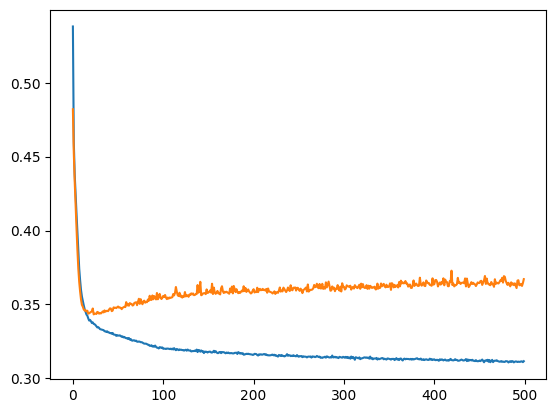

In [32]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])

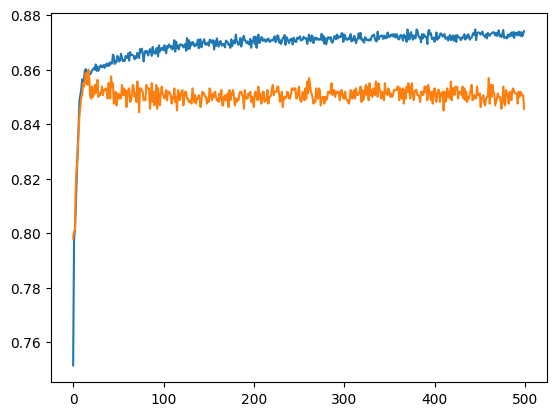

In [31]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])